<a href="https://colab.research.google.com/github/Pravallika41296/IANNWTF_Homework_Group24/blob/main/IANNWTF_Homework03_Group24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [2]:
#Function that converts the 250 characters sequence to a one-hot encoding vector format
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
  return onehot

In [3]:
#Loading 100,000 samples of training dataset 
train_seq, train_label = tfds.as_numpy(tfds.load(
    'genomics_ood',
    split='train[:10%]', 
    batch_size= -1, 
    as_supervised=True,
))
#Loading 1000 samples of test dataset 
test_seq, test_label = tfds.as_numpy(tfds.load(
    'genomics_ood',
    split='test[:1%]', 
    batch_size= -1, 
    as_supervised=True,
))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


In [4]:
#Preparing the training sequences and lables
genomic_train_seq = tf.data.Dataset.from_tensor_slices(train_seq)
genomic_train_seq = genomic_train_seq.map(onehotify)

genomic_train_label = tf.data.Dataset.from_tensor_slices(train_label)
genomic_train_label = genomic_train_label.map(lambda t : tf.one_hot(t, 10))

#Preparing the test sequences and lables
genomic_test_seq = tf.data.Dataset.from_tensor_slices(test_seq)
genomic_test_seq = genomic_test_seq.map(onehotify)

genomic_test_label = tf.data.Dataset.from_tensor_slices(test_label)
genomic_test_label = genomic_test_label.map(lambda t : tf.one_hot(t, 10))

#zipping the training sequences and labels 
train_dataset = tf.data.Dataset.zip((genomic_train_seq, genomic_train_label))
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.shuffle(buffer_size=128)

#zipping the test sequences and labels 
test_dataset = tf.data.Dataset.zip((genomic_test_seq, genomic_test_label))
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.shuffle(buffer_size=128)


In [5]:
#Building a simple feed forward model 
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [7]:

#Training the dataset: calculates the prediction, loss, gradient and updates the parameters 
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [8]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.4

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. 
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing the model before beginning the training 
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#checking how model performs on train data 
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

#training for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training 
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


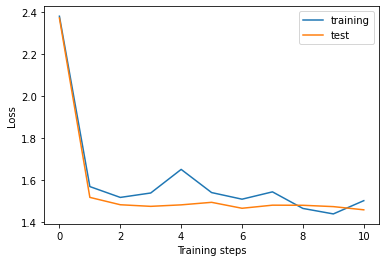

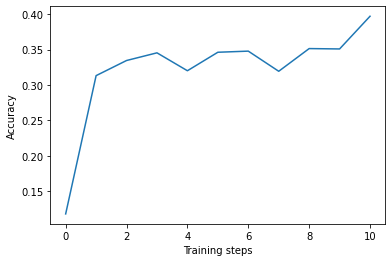

In [9]:
# Visualize accuracy and loss for training and test data. 
# first plot training and test loss.
# second plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()